In [1]:
#Import essential libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.optimizers import Adam
from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
# Set the environment to use GPU 0 for computation, if available
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

### Dataset

In [3]:
# Load the hourly dataset from a CSV file, fill missing values with 0, and display the data
dataset = pd.read_csv('Merged-update_hourly.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset[:]
data

,WS_S1,WS_S4,FLOW_S25A,GATE_S25A,HWS_S25A,TWS_S25A,FLOW_S25B,GATE_S25B,GATE_S25B2,HWS_S25B,TWS_S25B,PUMP_S25B,FLOW_S26,GATE_S26_1,GATE_S26_2,HWS_S26,TWS_S26,PUMP_S26,MEAN_RAIN
Time,,,,,,,,,,,,,,,,,,,
1/1/10 00:00,0.33,0.34,0.0,0.0,2.17,0.49,0.0,0.0,0.0,2.84,0.58,0.0,0.00,0.0,0.00,2.78,0.505,0.0,0.0
1/1/10 01:00,-0.29,-0.28,0.0,0.0,2.17,0.02,0.0,0.0,0.0,2.84,-0.07,0.0,0.00,0.0,0.00,2.78,-0.110,0.0,0.0
1/1/10 02:00,-0.81,-0.73,0.0,0.0,2.17,-0.49,0.0,0.0,0.0,2.84,-0.62,0.0,0.00,0.0,0.00,2.79,-0.650,0.0,0.0
1/1/10 03:00,-0.98,-0.85,0.0,0.0,2.15,-0.75,0.0,0.0,0.0,2.83,-0.82,0.0,0.00,0.0,0.00,2.79,-0.850,0.0,0.0
1/1/10 04:00,-0.69,-0.49,0.0,0.0,2.13,-0.55,0.0,0.0,0.0,2.84,-0.53,0.0,0.00,0.0,0.00,2.79,-0.550,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/20 19:00,1.24,1.19,0.0,0.0,1.92,1.25,0.0,0.0,0.0,2.86,1.31,0.0,456.34,0.0,2.61,2.49,1.290,0.0,0.0
12/31/20 20:00,1.62,1.61,0.0,0.0,1.92,1.64,0.0,0.0,0.0,2.88,1.68,0.0,380.19,0.0,2.62,2.48,1.660,0.0,0.0
12/31/20 21:00,1.98,1.90,0.0,0.0,1.93,2.00,0.0,0.0,0.0,2.89,2.04,0.0,287.12,0.0,2.62,2.54,2.040,0.0,0.0


### Dataset Information

In [4]:
print(list(data.columns))

['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A', 'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B', 'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26', 'TWS_S26', 'PUMP_S26', 'MEAN_RAIN']


### Pre-processing

In [5]:
# specify the number of lag hours
n_hours = 24*7
K = 24

#### Stage

In [6]:
# Extract stage-related features (water levels) and convert them into a supervised learning format with specified lags and horizon
# Stage --> 8 stages
stages = dataset[['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']]
print("stages.shape:", stages.shape)

stages_supervised = series_to_supervised(stages, n_hours, K)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (96432, 4)
stages_supervised.shape: (96241, 768)


#### Non-stage

In [7]:
# Extract non-stage features (e.g., flow, pump, rainfall) and convert them into a supervised format with adjusted lag
non_stages = data[['WS_S4', 'FLOW_S25A', 'FLOW_S25B', 'FLOW_S26', 'PUMP_S26', 'PUMP_S25B', 'MEAN_RAIN']]
print("non_stages.shape:", non_stages.shape)

non_stages_supervised = series_to_supervised(non_stages, n_hours-1, 1)
print("non_stages_supervised.shape:", non_stages_supervised.shape)

non_stages.shape: (96432, 7)
non_stages_supervised.shape: (96265, 1176)


In [9]:
# Trim the non-stage supervised data to align with the stage data by removing the first 24 rows
non_stages_supervised_cut = non_stages_supervised.iloc[24:, :]
print("non_stages_supervised_cut.shape:", non_stages_supervised_cut.shape)

non_stages_supervised_cut.shape: (96241, 1176)


### N_out, N_in, K

In [10]:
# Calculate the total number of features by combining stage and non-stage variables
n_features = stages.shape[1] + non_stages.shape[1]   # 1 rainfall + FGate_S25A + FGate_S25B + FGate_S26 + 8WS + PUMP_S26


### Concatenation

In [11]:
# Combine non-stage and stage supervised datasets into a single dataframe for model input
non_stages_supervised_cut.reset_index(drop=True, inplace=True)
stages_supervised.reset_index(drop=True, inplace=True)

all_data = concat([
                   non_stages_supervised_cut.iloc[:, :],

                   stages_supervised.iloc[:, :]],
                   axis=1)

print("all_data.shape:", all_data.shape)

all_data.shape: (96241, 1944)


### Train & Test set

In [12]:
# Split the data into training (80%) and testing sets based on time
all_data = all_data.values
n_train_hours = int(len(all_data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]    # 0 column is the rainfall to measure heavy/medium/light
test = all_data[n_train_hours:, :]

n_train_hours: 76992


In [13]:
# Confirm the shape of the training data
train.shape

(76992, 1944)

In [14]:
# test set (10/16/2018 - 12/30/3020)
# data.iloc[462368:, :]

### Normalization

In [15]:
n_hours

168

In [16]:
n_features

11

In [17]:
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -stages.shape[1]*K:]
test_X, test_y = test[:, :n_obs], test[:, -stages.shape[1]*K:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (76992, 1848) (76992, 96) (19249, 1848) (19249, 96)


In [18]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (76992, 168, 11) (76992, 96) (19249, 168, 11) (19249, 96)


### Model

In [19]:
# Simple MLP Model
model_mlp_60 = keras.Sequential()
model_mlp_60.add(layers.Flatten(input_shape=(train_X.shape[1], train_X.shape[2])))
model_mlp_60.add(layers.Dense(32, activation='relu'))
model_mlp_60.add(layers.Dense(8, activation='relu'))
model_mlp_60.add(layers.Dense(train_y.shape[1]))   # Regression -> No Need for Activation
model_mlp_60.summary()

c:\Users\ayoos\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 1848)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        59,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │           864 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,296 (235.53 KB)

 Trainable params: 60,296 (235.53 KB)

 Non-trainable params: 0 (0.00 B)

c:\Users\ayoos\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/2000
151/151 - 3s - 21ms/step - loss: 0.1327 - mae: 0.3235 - val_loss: 0.2461 - val_mae: 0.4431
Epoch 2/2000
151/151 - 1s - 5ms/step - loss: 0.1299 - mae: 0.3187 - val_loss: 0.2408 - val_mae: 0.4357
Epoch 3/2000
151/151 - 1s - 5ms/step - loss: 0.1245 - mae: 0.3077 - val_loss: 0.2296 - val_mae: 0.4183
Epoch 4/2000
151/151 - 1s - 5ms/step - loss: 0.1197 - mae: 0.2980 - val_loss: 0.2232 - val_mae: 0.4080
Epoch 5/2000
151/151 - 1s - 5ms/step - loss: 0.1162 - mae: 0.2913 - val_loss: 0.2172 - val_mae: 0.3998
Epoch 6/2000
151/151 - 1s - 5ms/step - loss: 0.1129 - mae: 0.2851 - val_loss: 0.2114 - val_mae: 0.3918
Epoch 7/2000
151/151 - 1s - 5ms/step - loss: 0.1096 - mae: 0.2791 - val_loss: 0.2056 - val_mae: 0.3840
Epoch 8/2000
151/151 - 1s - 5ms/step - loss: 0.1064 - mae: 0.2733 - val_loss: 0.1999 - val_mae: 0.3762
Epoch 9/2000
151/151 - 1s - 5ms/step - loss: 0.1032 - mae: 0.2675 - val_loss: 0.1942 - val_mae: 0.3688
Epoch 10/2000
151/151 - 1s - 4ms/step - loss: 0.1000 - mae: 0.2619 - val

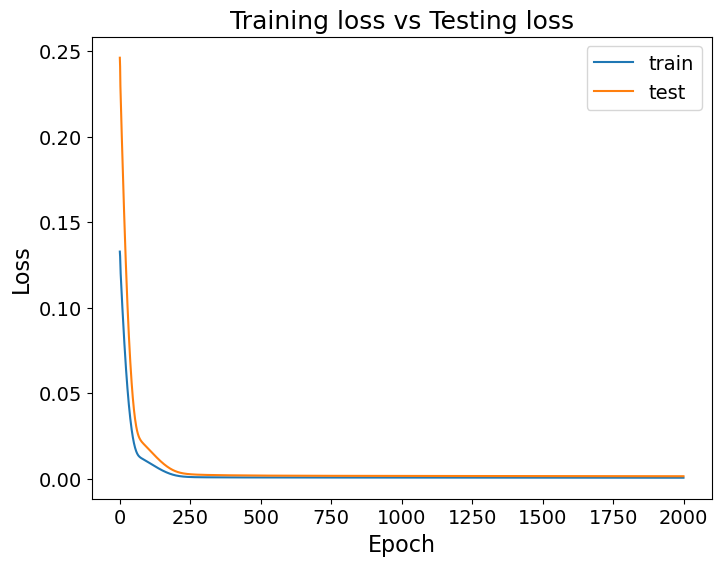

In [ ]:
# Compile and train the MLP model with Adam optimizer, early stopping, and model checkpointing; plot training vs. validation loss
lr = 0.00001
EPOCHS = 2000
model_mlp_60.compile(
              optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS),
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=500)



history = model_mlp_60.fit(train_X, train_y,
                    batch_size=512,
                    epochs=EPOCHS,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=False,
                               callbacks=[es])

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

### Prediction

In [23]:
# Load the trained MLP model for making predictions
model_load = model_mlp_60

#### Test set

In [24]:
# Generate predictions on the test set and inverse-transform them to the original scale
yhat = model_load.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

602/602 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
inv_y.shape, inv_yhat.shape (19249, 96) (19249, 96)


In [25]:
error_abs = abs(inv_yhat - inv_y)
# error_abs

In [26]:
error = inv_yhat - inv_y
# error

In [27]:
## 17544 = 24 * (365+366)
error_19_20 = error.iloc[-17544:, :]

In [28]:
len(error_19_20)

17544

In [29]:
# Save true values, predicted values, and errors to CSV files for further analysis
inv_y.to_csv('outputs 4/inv_y_mlp.csv')
inv_yhat.to_csv('outputs 4/inv_yhat_mlp.csv')
error.to_csv('outputs 4/error_mlp.csv')

### Performance

In [30]:
# Load true and predicted values, trim to the last two years, and prepare for performance evaluation
true_to_seires = pd.read_csv('outputs 4/inv_y_mlp.csv', index_col=0)
print(true_to_seires.shape)

true_to_seires = true_to_seires.iloc[-17521:, :]
print(true_to_seires.shape)

(19249, 96)
(17521, 96)


In [31]:
mlp_raw = pd.read_csv('outputs 4/inv_yhat_mlp.csv', index_col=0)


In [32]:
mlp = mlp_raw.iloc[-17521:, :]


In [33]:
print(mlp_raw.shape)

(19249, 96)


## MAE vs. prediction length

In [34]:
# Define a function to calculate Mean Absolute Error (MAE) between true and predicted values
def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))

In [35]:
# predicition for entire series
print(mae(true_to_seires, mlp))


0.15585593136238315


In [36]:
# predicition for 1-hr ahead
print(mae(true_to_seires.iloc[:, 0:4], mlp.iloc[:, 0:4]))


0.16163084325047913


In [37]:
# predicition for 8-hrs ahead
print(mae(true_to_seires.iloc[:, 28:32], mlp.iloc[:, 28:32]))

0.1645171753671132


In [38]:
# predicition for 16-hrs ahead
print(mae(true_to_seires.iloc[:, 60:64], mlp.iloc[:, 60:64]))

0.1551089608805743


In [40]:
# predicition for 24-hrs ahead
print(mae(true_to_seires.iloc[:, 92:96], mlp.iloc[:, 92:96]))

0.16208947915362326
